In [2]:
!pip install fbm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [2]:
!pip install matplotlib
!pip install scikit-learn
!pip install xgboost
!pip install tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbm import FBM
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.1.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.6 MB/s eta 0:00:00

[notice] A new release of

In [3]:
# fBmデータをプロットする関数
def plot_fbm(data, H):
    plt.figure(figsize=(10, 6))
    plt.plot(data, label=f'fBm with H={H}')
    plt.title(f'Fractional Brownian Motion with H={H}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# 分数ブラウン運動のデータを生成する関数
def generate_fbm(H, N):
    fbm = FBM(n=N-1, hurst=H, length=1, method='daviesharte')
    fbm_samples = fbm.fbm()
    return fbm_samples

# データを準備する関数
def prepare_data(data, past_steps=128, future_steps=128):  # past_steps, future_stepsを小さく
    X = []
    y_mean = []
    y_std = []
    total_steps = past_steps + future_steps
    for i in range(len(data) - total_steps):
        past_data = data[i:i+past_steps]
        future_data = data[i+past_steps:i+total_steps]
        X.append(past_data)
        y_mean.append(np.mean(future_data))
        y_std.append(np.std(future_data))
    return np.array(X), np.array(y_mean), np.array(y_std)

# モデルの訓練と評価を行う関数
def train_and_evaluate(X_train, y_train_mean, y_train_std, X_test, y_test_mean, y_test_std, model_name='RandomForest'):
    if model_name == 'RandomForest':
        model_mean = RandomForestRegressor(n_estimators=50, random_state=42)  # 木の数を減らす
        model_std = RandomForestRegressor(n_estimators=50, random_state=42)
    elif model_name == 'XGBoost':
        model_mean = xgb.XGBRegressor(n_estimators=50, random_state=42)  # 木の数を減らす
        model_std = xgb.XGBRegressor(n_estimators=50, random_state=42)
    else:
        raise ValueError("Invalid model name")

    # 平均値の予測モデルを訓練
    model_mean.fit(X_train, y_train_mean)
    # 標準偏差の予測モデルを訓練
    model_std.fit(X_train, y_train_std)

    # 予測
    y_pred_mean = model_mean.predict(X_test)
    y_pred_std = model_std.predict(X_test)

    # 評価
    mse_mean = mean_squared_error(y_test_mean, y_pred_mean)
    mse_std = mean_squared_error(y_test_std, y_pred_std)

    print(f"{model_name} Model Evaluation:")
    print(f"Mean MSE: {mse_mean}")
    print(f"Std MSE: {mse_std}")

    return model_mean, model_std

Generating fBm data...


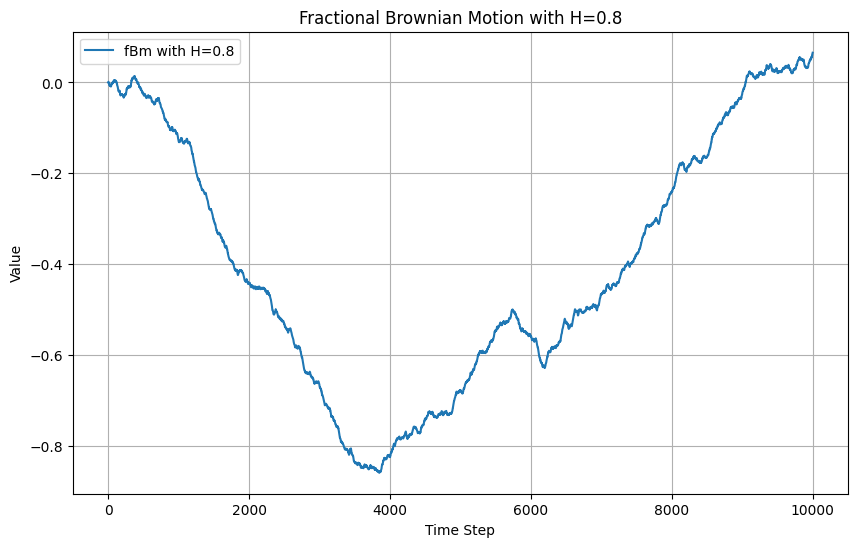

Preparing data...
RandomForest Model Evaluation:
Mean MSE: 0.00426551428958007
Std MSE: 3.5761780006333115e-05
XGBoost Model Evaluation:
Mean MSE: 0.005866385546232612
Std MSE: 3.11555957172371e-05


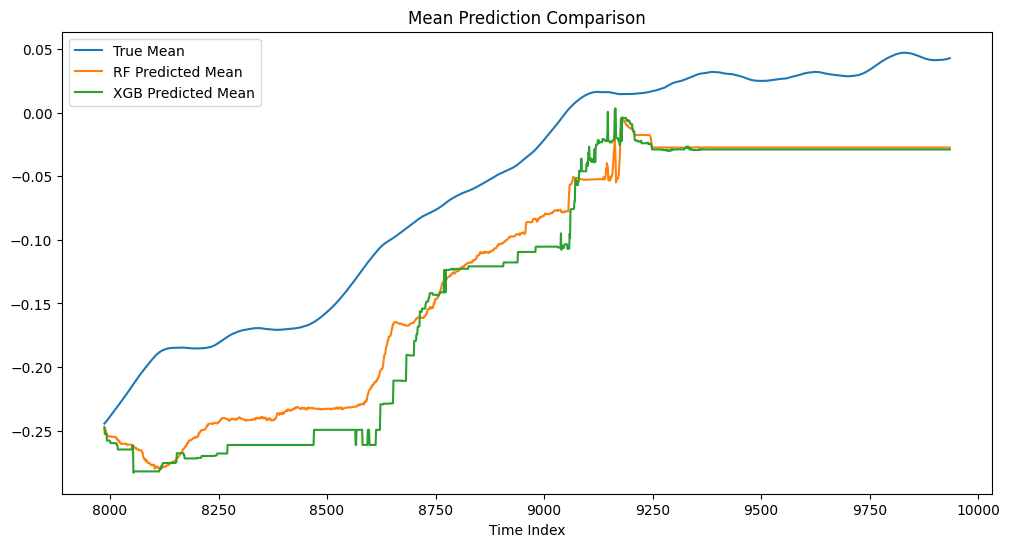

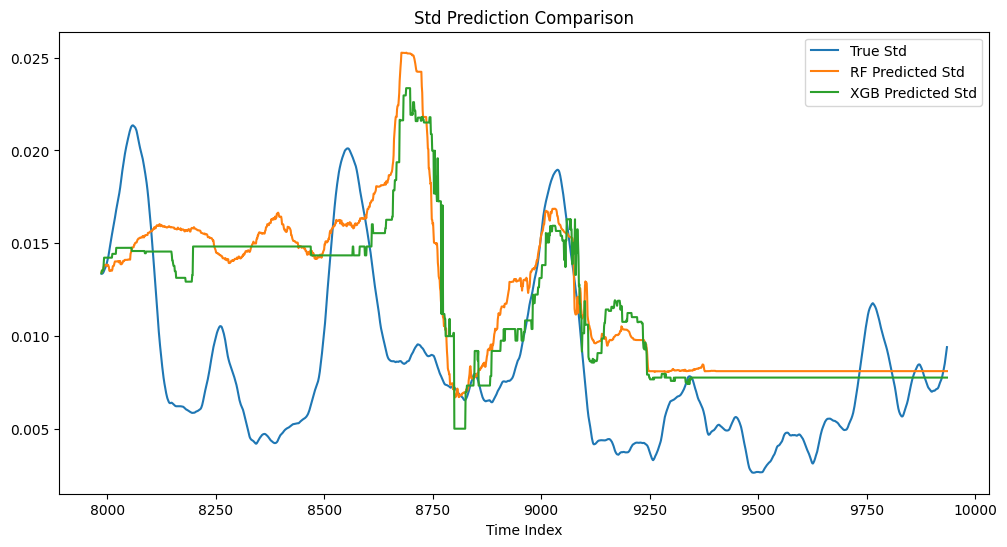

In [4]:
# 主な実験の流れ
def main():
    # パラメータ設定
    H = 0.8  # Hurst指数
    N = 10000  # データの総ステップ数
    past_steps = 128
    future_steps = 128

    # データ生成
    print("Generating fBm data...")
    data = generate_fbm(H, N)

    # fBmデータのプロット
    plot_fbm(data, H)

    # データの準備
    print("Preparing data...")
    X, y_mean, y_std = prepare_data(data, past_steps, future_steps)

    # 訓練データとテストデータに分割
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train_mean, y_test_mean = y_mean[:split_index], y_mean[split_index:]
    y_train_std, y_test_std = y_std[:split_index], y_std[split_index:]

    # ランダムフォレストモデルの訓練と評価
    rf_mean_model, rf_std_model = train_and_evaluate(X_train, y_train_mean, y_train_std, X_test, y_test_mean, y_test_std, model_name='RandomForest')

    # XGBoostモデルの訓練と評価
    xgb_mean_model, xgb_std_model = train_and_evaluate(X_train, y_train_mean, y_train_std, X_test, y_test_mean, y_test_std, model_name='XGBoost')

    # テストデータの開始位置を計算
    test_start_index = split_index + past_steps

    # 各サンプルが対応する時間インデックスを計算（未来データの中央を取る）
    time_indices = np.arange(test_start_index, test_start_index + len(y_test_mean)) + future_steps // 2

    # 平均予測の比較（時間軸を調整）
    plt.figure(figsize=(12, 6))
    plt.plot(time_indices, y_test_mean, label='True Mean')
    plt.plot(time_indices, rf_mean_model.predict(X_test), label='RF Predicted Mean')
    plt.plot(time_indices, xgb_mean_model.predict(X_test), label='XGB Predicted Mean')
    plt.legend()
    plt.title('Mean Prediction Comparison')
    plt.xlabel('Time Index')
    plt.show()

    # 標準偏差予測の比較（時間軸を調整）
    plt.figure(figsize=(12, 6))
    plt.plot(time_indices, y_test_std, label='True Std')
    plt.plot(time_indices, rf_std_model.predict(X_test), label='RF Predicted Std')
    plt.plot(time_indices, xgb_std_model.predict(X_test), label='XGB Predicted Std')
    plt.legend()
    plt.title('Std Prediction Comparison')
    plt.xlabel('Time Index')
    plt.show()

if __name__ == "__main__":
    main()

Generating fBm data...


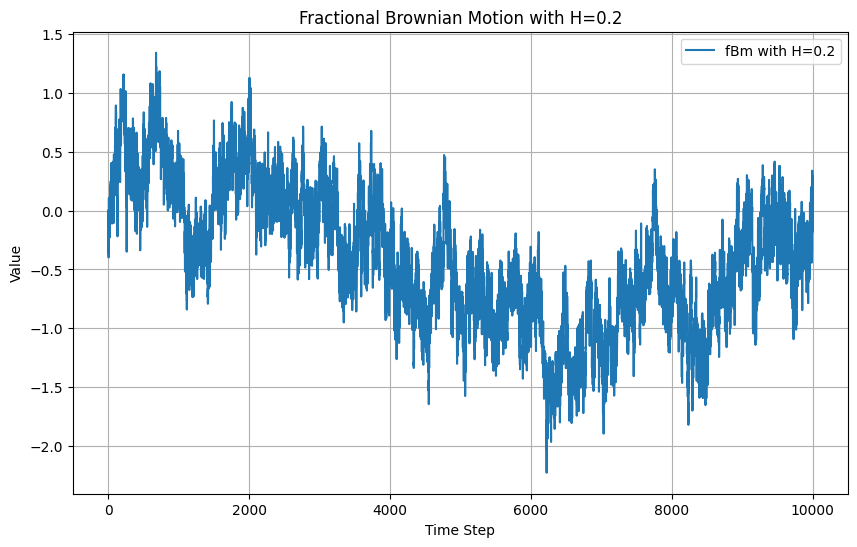

Preparing data...
RandomForest Model Evaluation:
Mean MSE: 0.047972705006246785
Std MSE: 0.0032459543964660368
XGBoost Model Evaluation:
Mean MSE: 0.05760104807449607
Std MSE: 0.0036634179086227924


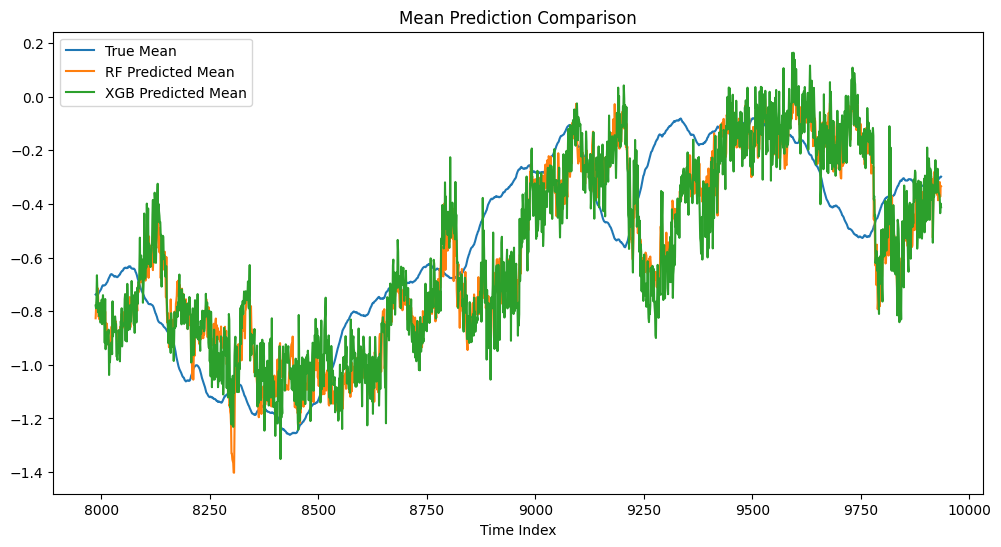

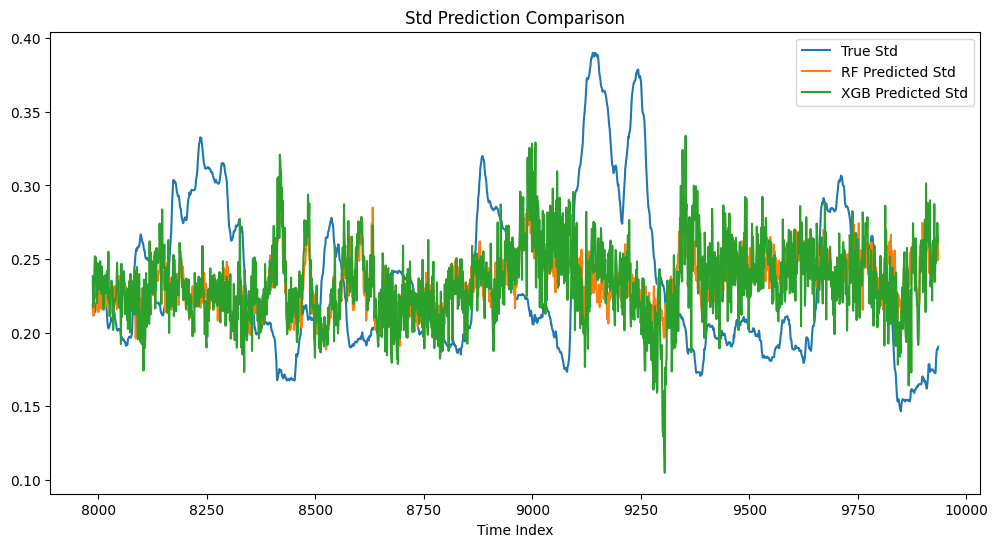

In [5]:
# 主な実験の流れ
def main():
    # パラメータ設定
    H = 0.2  # Hurst指数
    N = 10000  # データの総ステップ数
    past_steps = 128
    future_steps = 128

    # データ生成
    print("Generating fBm data...")
    data = generate_fbm(H, N)

    # fBmデータのプロット
    plot_fbm(data, H)

    # データの準備
    print("Preparing data...")
    X, y_mean, y_std = prepare_data(data, past_steps, future_steps)

    # 訓練データとテストデータに分割
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train_mean, y_test_mean = y_mean[:split_index], y_mean[split_index:]
    y_train_std, y_test_std = y_std[:split_index], y_std[split_index:]

    # ランダムフォレストモデルの訓練と評価
    rf_mean_model, rf_std_model = train_and_evaluate(X_train, y_train_mean, y_train_std, X_test, y_test_mean, y_test_std, model_name='RandomForest')

    # XGBoostモデルの訓練と評価
    xgb_mean_model, xgb_std_model = train_and_evaluate(X_train, y_train_mean, y_train_std, X_test, y_test_mean, y_test_std, model_name='XGBoost')

    # テストデータの開始位置を計算
    test_start_index = split_index + past_steps

    # 各サンプルが対応する時間インデックスを計算（未来データの中央を取る）
    time_indices = np.arange(test_start_index, test_start_index + len(y_test_mean)) + future_steps // 2

    # 平均予測の比較（時間軸を調整）
    plt.figure(figsize=(12, 6))
    plt.plot(time_indices, y_test_mean, label='True Mean')
    plt.plot(time_indices, rf_mean_model.predict(X_test), label='RF Predicted Mean')
    plt.plot(time_indices, xgb_mean_model.predict(X_test), label='XGB Predicted Mean')
    plt.legend()
    plt.title('Mean Prediction Comparison')
    plt.xlabel('Time Index')
    plt.show()

    # 標準偏差予測の比較（時間軸を調整）
    plt.figure(figsize=(12, 6))
    plt.plot(time_indices, y_test_std, label='True Std')
    plt.plot(time_indices, rf_std_model.predict(X_test), label='RF Predicted Std')
    plt.plot(time_indices, xgb_std_model.predict(X_test), label='XGB Predicted Std')
    plt.legend()
    plt.title('Std Prediction Comparison')
    plt.xlabel('Time Index')
    plt.show()

if __name__ == "__main__":
    main()

Generating fBm data...


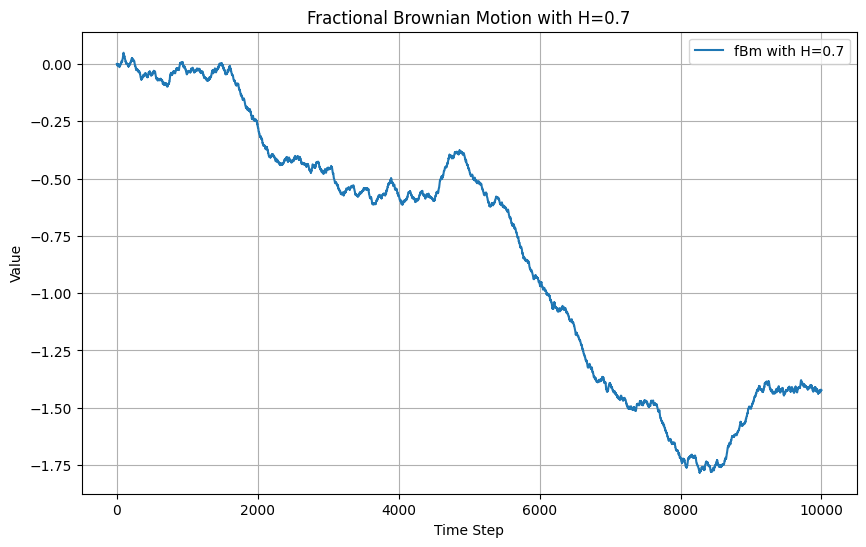

Preparing data...
RandomForest Model Evaluation:
Mean MSE: 0.003466501923776034
Std MSE: 7.249502485802788e-05
XGBoost Model Evaluation:
Mean MSE: 0.004297425241373556
Std MSE: 6.019439224850535e-05


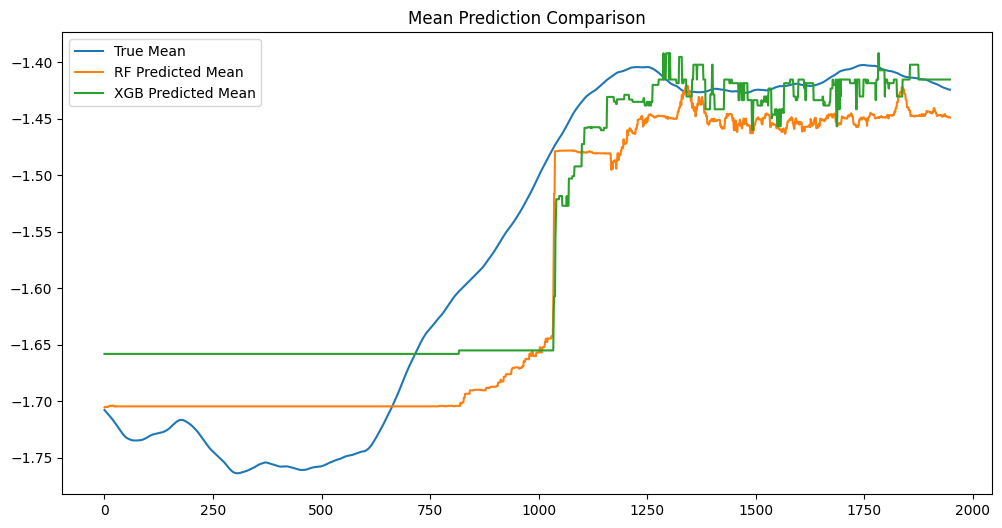

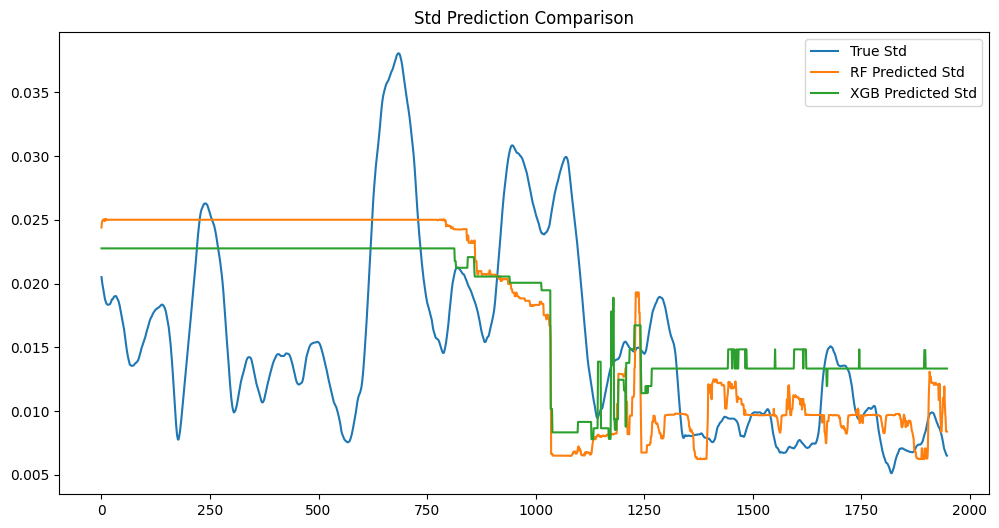

In [4]:
# fBmデータをプロットする関数
def plot_fbm(data, H):
    plt.figure(figsize=(10, 6))
    plt.plot(data, label=f'fBm with H={H}')
    plt.title(f'Fractional Brownian Motion with H={H}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# 主な実験の流れ（fBmのプロット追加）
def main():
    # パラメータ設定
    H = 0.7  # Hurst指数
    N = 10000  # データの総ステップ数
    past_steps = 128
    future_steps = 128

    # データ生成
    print("Generating fBm data...")
    data = generate_fbm(H, N)

    # fBmデータのプロット
    plot_fbm(data, H)

    # データの準備
    print("Preparing data...")
    X, y_mean, y_std = prepare_data(data, past_steps, future_steps)

    # 訓練データとテストデータに分割
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train_mean, y_test_mean = y_mean[:split_index], y_mean[split_index:]
    y_train_std, y_test_std = y_std[:split_index], y_std[split_index:]

    # ランダムフォレストモデルの訓練と評価
    rf_mean_model, rf_std_model = train_and_evaluate(X_train, y_train_mean, y_train_std, X_test, y_test_mean, y_test_std, model_name='RandomForest')

    # XGBoostモデルの訓練と評価
    xgb_mean_model, xgb_std_model = train_and_evaluate(X_train, y_train_mean, y_train_std, X_test, y_test_mean, y_test_std, model_name='XGBoost')

    # 平均予測の比較
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_mean, label='True Mean')  # 全データをプロット
    plt.plot(rf_mean_model.predict(X_test), label='RF Predicted Mean')
    plt.plot(xgb_mean_model.predict(X_test), label='XGB Predicted Mean')
    plt.legend()
    plt.title('Mean Prediction Comparison')
    plt.show()

    # 標準偏差予測の比較
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_std, label='True Std')  # 全データをプロット
    plt.plot(rf_std_model.predict(X_test), label='RF Predicted Std')
    plt.plot(xgb_std_model.predict(X_test), label='XGB Predicted Std')
    plt.legend()
    plt.title('Std Prediction Comparison')
    plt.show()

if __name__ == "__main__":
    main()

最適ハイパラ見つけてそれ使うver

Generating fBm data...


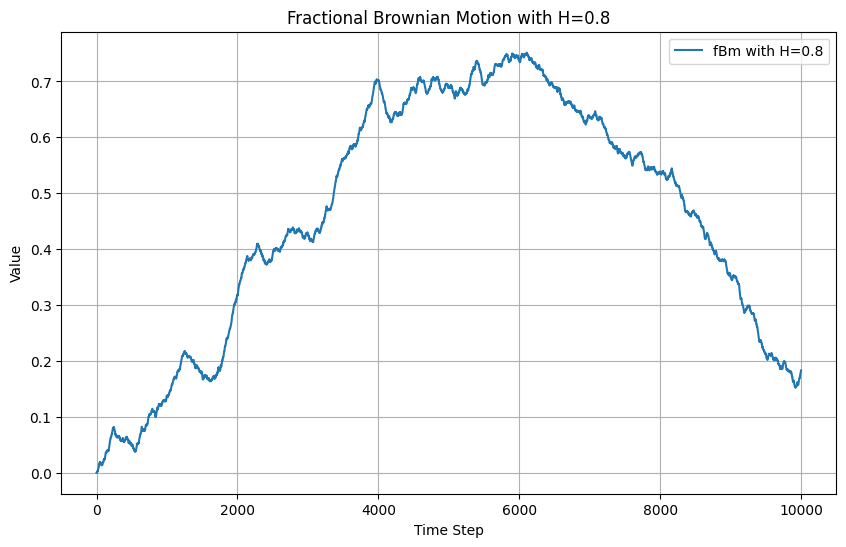

Preparing data...
Tuning hyperparameters for RandomForest - Mean Prediction...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fbm import FBM
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tqdm import tqdm

# fBmデータをプロットする関数
def plot_fbm(data, H):
    plt.figure(figsize=(10, 6))
    plt.plot(data, label=f'fBm with H={H}')
    plt.title(f'Fractional Brownian Motion with H={H}')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# 分数ブラウン運動のデータを生成する関数
def generate_fbm(H, N):
    fbm = FBM(n=N-1, hurst=H, length=1, method='daviesharte')
    fbm_samples = fbm.fbm()
    return fbm_samples

# データを準備する関数
def prepare_data(data, past_steps=128, future_steps=128):
    X = []
    y_mean = []
    y_std = []
    total_steps = past_steps + future_steps
    for i in range(len(data) - total_steps):
        past_data = data[i:i+past_steps]
        future_data = data[i+past_steps:i+total_steps]
        X.append(past_data)
        y_mean.append(np.mean(future_data))
        y_std.append(np.std(future_data))
    return np.array(X), np.array(y_mean), np.array(y_std)

# ハイパーパラメータのチューニングを行う関数
def hyperparameter_tuning(model, param_grid, X_train, y_train, model_name='Model'):
    # RandomizedSearchCVを使用
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=50,
        cv=3,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {random_search.best_params_}")
    return random_search.best_estimator_

# モデルの訓練と評価を行う関数
def train_and_evaluate(X_train, y_train_mean, y_train_std, X_test, y_test_mean, y_test_std, model_name='RandomForest'):
    if model_name == 'RandomForest':
        # ランダムフォレストのハイパーパラメータ範囲を定義
        param_grid = {
            'n_estimators': [100, 200, 500],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'bootstrap': [True, False]
        }
        base_model = RandomForestRegressor(random_state=42)
    elif model_name == 'XGBoost':
        # XGBoostのハイパーパラメータ範囲を定義
        param_grid = {
            'n_estimators': [100, 200, 500],
            'max_depth': [3, 5, 7, 10],
            'learning_rate': [0.01, 0.05, 0.1],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
        base_model = xgb.XGBRegressor(random_state=42)
    else:
        raise ValueError("Invalid model name")

    # 平均値の予測モデルをチューニング
    print(f"Tuning hyperparameters for {model_name} - Mean Prediction...")
    model_mean = hyperparameter_tuning(base_model, param_grid, X_train, y_train_mean, model_name)

    # 標準偏差の予測モデルをチューニング
    print(f"Tuning hyperparameters for {model_name} - Std Prediction...")
    model_std = hyperparameter_tuning(base_model, param_grid, X_train, y_train_std, model_name)

    # 予測
    y_pred_mean = model_mean.predict(X_test)
    y_pred_std = model_std.predict(X_test)

    # 評価
    mse_mean = mean_squared_error(y_test_mean, y_pred_mean)
    mse_std = mean_squared_error(y_test_std, y_pred_std)

    print(f"{model_name} Model Evaluation:")
    print(f"Mean MSE: {mse_mean}")
    print(f"Std MSE: {mse_std}")

    return model_mean, model_std

# 主な実験の流れ
def main():
    # パラメータ設定
    H = 0.8  # Hurst指数
    N = 10000  # データの総ステップ数
    past_steps = 128
    future_steps = 128

    # データ生成
    print("Generating fBm data...")
    data = generate_fbm(H, N)

    # fBmデータのプロット
    plot_fbm(data, H)

    # データの準備
    print("Preparing data...")
    X, y_mean, y_std = prepare_data(data, past_steps, future_steps)

    # 訓練データとテストデータに分割
    split_ratio = 0.8
    split_index = int(len(X) * split_ratio)
    X_train, X_test = X[:split_index], X[split_index:]
    y_train_mean, y_test_mean = y_mean[:split_index], y_mean[split_index:]
    y_train_std, y_test_std = y_std[:split_index], y_std[split_index:]

    # ランダムフォレストモデルの訓練と評価
    rf_mean_model, rf_std_model = train_and_evaluate(
        X_train, y_train_mean, y_train_std, X_test, y_test_mean, y_test_std, model_name='RandomForest')

    # XGBoostモデルの訓練と評価
    xgb_mean_model, xgb_std_model = train_and_evaluate(
        X_train, y_train_mean, y_train_std, X_test, y_test_mean, y_test_std, model_name='XGBoost')

    # テストデータの開始位置を計算
    test_start_index = split_index + past_steps

    # 各サンプルが対応する時間インデックスを計算（未来データの中央を取る）
    time_indices = np.arange(test_start_index, test_start_index + len(y_test_mean)) + future_steps // 2

    # 平均予測の比較（時間軸を調整）
    plt.figure(figsize=(12, 6))
    plt.plot(time_indices, y_test_mean, label='True Mean')
    plt.plot(time_indices, rf_mean_model.predict(X_test), label='RF Predicted Mean')
    plt.plot(time_indices, xgb_mean_model.predict(X_test), label='XGB Predicted Mean')
    plt.legend()
    plt.title('Mean Prediction Comparison')
    plt.xlabel('Time Index')
    plt.show()

    # 標準偏差予測の比較（時間軸を調整）
    plt.figure(figsize=(12, 6))
    plt.plot(time_indices, y_test_std, label='True Std')
    plt.plot(time_indices, rf_std_model.predict(X_test), label='RF Predicted Std')
    plt.plot(time_indices, xgb_std_model.predict(X_test), label='XGB Predicted Std')
    plt.legend()
    plt.title('Std Prediction Comparison')
    plt.xlabel('Time Index')
    plt.show()

if __name__ == "__main__":
    main()